In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [3]:
rating = pd.read_csv('../Data/not_spare_rating.csv')
rating.head()

,product_id,content,customer_id,user_name,stars,comment_id
0,58441480,NaN,6024679,Nhung Phạm,5,4864338
1,58441480,NaN,11333255,Nguyen Nang Quang,4,4589409
2,3071851,"Sách có hình vẽ và nội dung rất đáng yêu, là m...",6292041,Phan Thi Hoan,5,2831147
3,3071851,Sách dễ thương. Bé nhà mình rất thích :),10905691,Yến Nhi,5,3477988
4,3071851,Sách dễ thương,7933673,Ngoc Dung,5,4633043


In [4]:
product_index = np.unique(rating['product_id'])
product_index = np.sort(product_index)
np.where(product_index==324921)[0][0]
customer_index = np.unique(rating['customer_id'])
customer_index = np.sort(customer_index)
rating['id_book'] = rating['product_id'].apply(lambda x: np.where(product_index==int(x))[0][0])
rating['id_customer'] = rating['customer_id'].apply(lambda x: np.where(customer_index==int(x))[0][0])
rating.head()

,product_id,content,customer_id,user_name,stars,comment_id,id_book,id_customer
0,58441480,NaN,6024679,Nhung Phạm,5,4864338,5019,571
1,58441480,NaN,11333255,Nguyen Nang Quang,4,4589409,5019,990
2,3071851,"Sách có hình vẽ và nội dung rất đáng yêu, là m...",6292041,Phan Thi Hoan,5,2831147,1610,607
3,3071851,Sách dễ thương. Bé nhà mình rất thích :),10905691,Yến Nhi,5,3477988,1610,958
4,3071851,Sách dễ thương,7933673,Ngoc Dung,5,4633043,1610,767


In [5]:
rating.duplicated(["product_id","customer_id", "stars"]).sum()

5

In [6]:
rating.drop_duplicates(["product_id","customer_id", "stars"], inplace=True)

## Split data train test

In [10]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(rating, test_size=0.2, random_state=43)
# split_value = int(len(rating) * 0.80)
# train_data = rating[:split_value]
# test_data = rating[split_value:]

## Analysis data

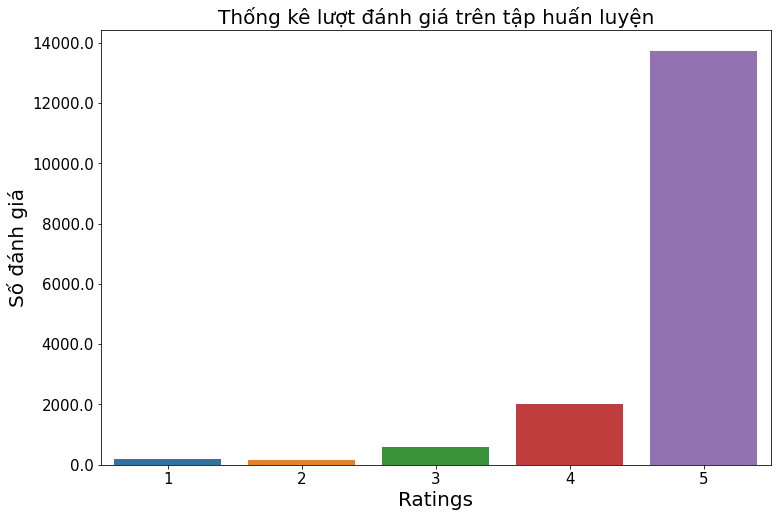

In [11]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="stars", data=train_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Thống kê lượt đánh giá trên tập huấn luyện", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Số đánh giá", fontsize = 20)
plt.show()

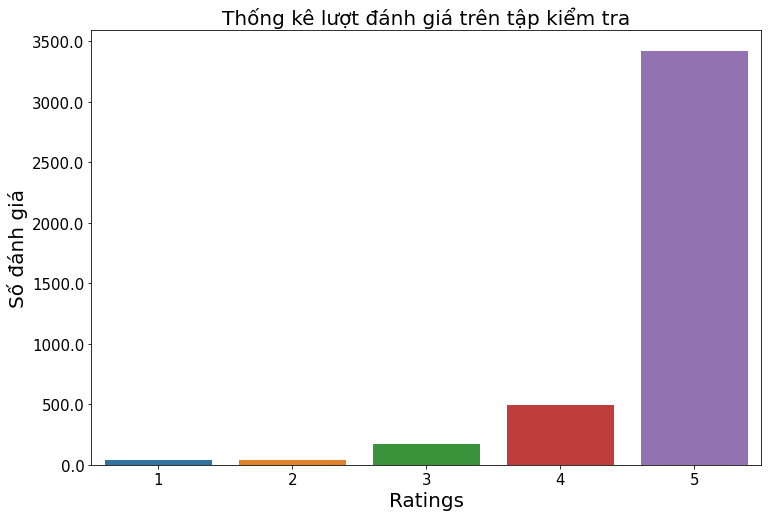

In [13]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="stars", data=test_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Thống kê lượt đánh giá trên tập kiểm tra", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Số đánh giá", fontsize = 20)
plt.show()

## Create User-Item Sparse Matrix

In [14]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.stars, (df.id_customer, df.id_book)))
    return sparse_data

In [15]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

In [16]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

In [17]:
# Find Average Gloabal Rating of Movie
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 4.737195633921075


In [18]:
# A Generic Method to Calculate Average Rating from Sparse Matrix
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [19]:
# calculate average user rating
average_rating_user = get_average_rating(train_sparse_data, True)

In [20]:
# calculate average book rating
avg_rating_movie = get_average_rating(train_sparse_data, False)

## Check Cold Start Problem for Users

In [21]:
total_users = len(np.unique(rating["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 1382
No. of Users in train data= 1382
No. of Users not present in train data = 0(0.0%)


## Check Cold Start Problem for the Movies

In [22]:
total_movies = len(np.unique(rating["id_book"]))
train_movies = len(avg_rating_movie)
uncommonMovies = total_movies - train_movies
                  
print("Total no. of Movies = {}".format(total_movies))
print("No. of Movies in train data= {}".format(train_movies))
print("No. of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies = 5289
No. of Movies in train data= 4939
No. of Movies not present in train data = 350(7.0%)


## Computation of user similarity to find similarities of top 100 users

In [23]:
unique_user = np.unique(rating['id_customer'])
len(unique_user)

1382

In [24]:
train_sparse_data.shape

(1382, 5289)

In [25]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    # print(row_index)
    # print(len(col_index))
    similar_arr = np.zeros(137000).reshape(1370,100)
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

In [26]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [27]:
similar_user_matrix[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03430779, 0.05698029, 0.06362848, 0.06565322, 0.06606455,
       0.06721661, 0.06804138, 0.07308817, 0.0745356 , 0.07729905,
       0.07905694, 0.07921553, 0.07961622, 0.07977821, 0.08035304,
       0.08417938, 0.0846499 , 0.08574929, 0.08821622, 0.08838835,
       0.08838835, 0.08861015, 0.09128709, 0.09147787, 0.09449112,
       0.09449112, 0.0971399 , 0.09882118, 0.09913145, 0.09925833,
       0.10056475, 0.10206207, 0.10292337, 0.10362833, 0.10526899,
       0.10660036, 0.10660036, 0.10838875, 0.10984369, 0.1118034 ,
       0.1118034 , 0.11286653, 0.11387188, 0.11605959, 0.11785

## Load Book Titles

In [28]:
books = pd.read_csv('../Data/clean_books.csv')
books.head()

,id,sku,name,url_path,book_cover,short_description,price,list_price,price_usd,discount,...,favourite_count,thumbnail_url,productset_group_name,description,publisher,authors,stock_item,big_category,sub_category,clean_description
0,58390336,3380735508079,Python cơ bản,python-co-ban-p58390336.html?spid=58390337,Bìa mềm,SÁCH PYTHON CƠ BẢN\nHiện nay ngôn ngữ lập trìn...,125000,125000,5.343,0,...,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Sách Công Nghệ Thông Tin, Lập Trình",SÁCH PYTHON CƠ BẢN\nHiện nay ngôn ngữ lập trìn...,NXB Đại Học Quốc Gia Hà Nội,Bùi Việt Hà,5.0,Sách Công Nghệ Thông Tin,Lập Trình,sách python cơ_bản ngôn_ngữ lập_trình bậc pyth...
1,1664525,2147399986992,Giáo Trình Kỹ Thuật Lập Trình C Căn Bản Và Nân...,giao-trinh-ky-thuat-lap-trinh-c-can-ban-va-nan...,Bìa mềm,Giáo trình kỹ thuật lập trình C căn bản và nân...,67500,135000,2.885,67500,...,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Sách Công Nghệ Thông Tin, Lập Trình",Giáo trình kỹ thuật lập trình C căn bản và nân...,Huy Hoàng Bookstore,Nhiều Tác Giả,801.0,Sách Công Nghệ Thông Tin,Lập Trình,giáo_trình kỹ_thuật lập_trình căn_bản nâng hìn...
2,55573620,6752050391860,Giáo Trình Tự Học AutoCAD 2019 Thực Hành Bằng ...,giao-trinh-tu-hoc-autocad-2019-thuc-hanh-bang-...,Bìa mềm,Mục lục:\nCHƯƠNG 1: BẮT ĐẦU AUTOCAD 2019 \nCHƯ...,110000,110000,4.702,0,...,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Sách Công Nghệ Thông Tin, Thiết Kế - Đồ Họa",Mục lục:\nCHƯƠNG 1: BẮT ĐẦU AUTOCAD 2019 \nCHƯ...,Công Ty TNHH Văn Hóa - Thế Giới Sách Việt,Nhiều Tác Giả,12.0,Sách Công Nghệ Thông Tin,Thiết Kế - Đồ Họa,mục_lục chương autocad chương kỹ_năng cơ_bản c...
3,24889348,3747885152000,Lập trình hướng đối tượng JAVA core dành cho n...,lap-trinh-huong-doi-tuong-java-core-danh-cho-n...,NaN,I. Đôi điều về tác giả\nTôi là NEOS.THÀNH (Ngu...,189000,299000,8.079,110000,...,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Sách Công Nghệ Thông Tin, Lập Trình",I. Đôi điều về tác giả\nTôi là NEOS.THÀNH (Ngu...,-,Nhiều Tác Giả,NaN,Sách Công Nghệ Thông Tin,Lập Trình,đôi tác_giả neos thành nguyễn văn thành lập_tr...
4,37667006,5950833882104,Combo Giáo Trình Kỹ Thuật Lập Trình C Căn Bản ...,combo-giao-trinh-ky-thuat-lap-trinh-c-can-ban-...,Bìa mềm,Giáo trình kỹ thuật lập trình C căn bản và nân...,223400,280000,9.550,56600,...,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Sách Công Nghệ Thông Tin, Lập Trình",Giáo trình kỹ thuật lập trình C căn bản và nân...,Huy Hoàng Bookstore,Nhiều Tác Giả,97.0,Sách Công Nghệ Thông Tin,Lập Trình,giáo_trình kỹ_thuật lập_trình căn_bản nâng hìn...


## Compute Book Similarity Matrix

In [29]:
def compute_movie_similarity_count(sparse_matrix, movie_titles_df, movie_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero()
    return no_of_similar_movies

In [30]:
similar_movies = compute_movie_similarity_count(train_sparse_data, books, 3)
print("Similar Movies = {}".format(similar_movies))

Similar Movies = (3747885152000, 10)


## Create Sample Sparse Matrix

In [31]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

In [32]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

In [33]:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

## A Generic Method to Generate Similar Featuires.

In [34]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(movie)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[user]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_movies[movie])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["user_id", "movie_id", "gloabl_average", "similar_user_rating1", 
                                                               "similar_user_rating2", "similar_user_rating3", 
                                                               "similar_user_rating4", "similar_user_rating5", 
                                                               "similar_movie_rating1", "similar_movie_rating2", 
                                                               "similar_movie_rating3", "similar_movie_rating4", 
                                                               "similar_movie_rating5", "user_average", 
                                                               "movie_average", "rating"])
    return new_features_df

In [35]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [36]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,164,142,4.884615,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.5,4.0,0.0,0.0,0.0,0.0
1,218,142,4.884615,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0,0.0,0.0
2,1112,663,4.884615,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0
3,871,710,4.884615,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0
4,958,802,4.884615,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0


In [37]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [38]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,1275,2049,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3,0.0,0.0,0.0,0.0,0.0
1,195,2774,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,0.0,0.0,0.0,0.0,0.0


## Building Machine Learning Model

In [41]:
x_train = train_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

x_test = test_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

y_train = train_new_similar_features["rating"]

y_test = test_new_similar_features["rating"]

In [42]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [43]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=10, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=False, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [44]:
y_pred_test = clf.predict(x_test)

In [45]:
y_pred_test

array([0., 0.], dtype=float32)

In [46]:
y_test

0    0.0
1    0.0
Name: rating, dtype: float64

In [163]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 0.0


## Plot Feature Importance

In [164]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

In [165]:
 plot_importance(xgb, clf)

ValueError: Booster.get_score() results in empty